# Ploting Particle tracking outputs

In [1]:
# Imports
import os
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import geopandas as gpd
# NetCDF data handling
from netCDF4 import Dataset
# Visualization: general plotting, Cartopy, and Matplotlib utilities
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import matplotlib.cm as cm

# FVCOM-specific visualization and utility tools
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
from pylag.processing.utils import get_grid_bands
from pylag.grid_metrics import create_fvcom_grid_metrics_file


# Regridding, viewing, and garbage collection utilities
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
import gc

# Inputs

In [2]:
# Particle tracking output directory
cwd = os.getcwd()
MODELLING_DIR = '/home/abolmaal/modelling/FVCOM/Huron'.format(cwd)
try:
    os.makedirs(MODELLING_DIR)
except FileExistsError:
    pass


# Create input sub-directory for input files
input_dir = '{}/input'.format(MODELLING_DIR)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Create grid file sub-directory
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

# pylag outputfiles
# Create output sub-directory
output_dir = '{}/output'.format(MODELLING_DIR)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create Figure sub-directory
fig_dir = '{}/figures'.format(MODELLING_DIR)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)


# output path saving the figure
fig_path_initilapositions = os.path.join(fig_dir, 'initial_positions_LakeHuron_multigrouppoint_intersection.jpeg')

Parameters

In [3]:
# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface

# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'


In [4]:
#Figure Parameters
# Create figure
font_size = 15
figsize=(26., 26.)
cmap = colourmap('h_r')
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)


# Bathymetry 

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
# make a color scale of light green to blue 
GnBu = LinearSegmentedColormap.from_list('GnBu', [(0, '#f0f9e8'), (0.5, '#bae4bc'), (1, '#7bccc4')], N=256)
bathy_cmap = GnBu

ds.close()
del(ds)

# extends 
#Lake Huron extents
extents_LH = np.array([275, 277.69, 43, 46.3], dtype=float)
extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)
#
batch_size = 50
#
zoom_extents_1 = [276.5, 276.8, 44.8, 45.5]  # Zoom-in 1
zoom_extents_2 = [276.5, 276, 43.58, 44]  # Zoom-in 2
zoom_extents_3 = [277.5, 277, 43.5, 44]  # Zoom-in 3

# Plotting the Data

## Plot Initial position files

In [4]:
# Read the initial position file into a pandas DataFrame and skip the first line
df = pd.read_csv(f"{MODELLING_DIR}/input/initial_position/initial_positions_releasezone_intersection_multigroup_2_lastrevised.dat", sep = ' ',skiprows=1)
group_id = df.iloc[:,0]
lons = df.iloc[:,1] 
lats= df.iloc[:,2]


In [5]:
df

,0,275.3469,45.7511,0.1
0,0,275.3402,45.7544,0
1,0,275.3436,45.7544,0
2,0,275.3469,45.7544,0
3,0,275.3502,45.7544,0
4,0,275.3536,45.7544,0
...,...,...,...,...
3358,162,276.1754,43.6813,0
3359,162,276.1787,43.6813,0
3360,162,276.1820,43.6813,0
3361,162,276.1854,43.6813,0


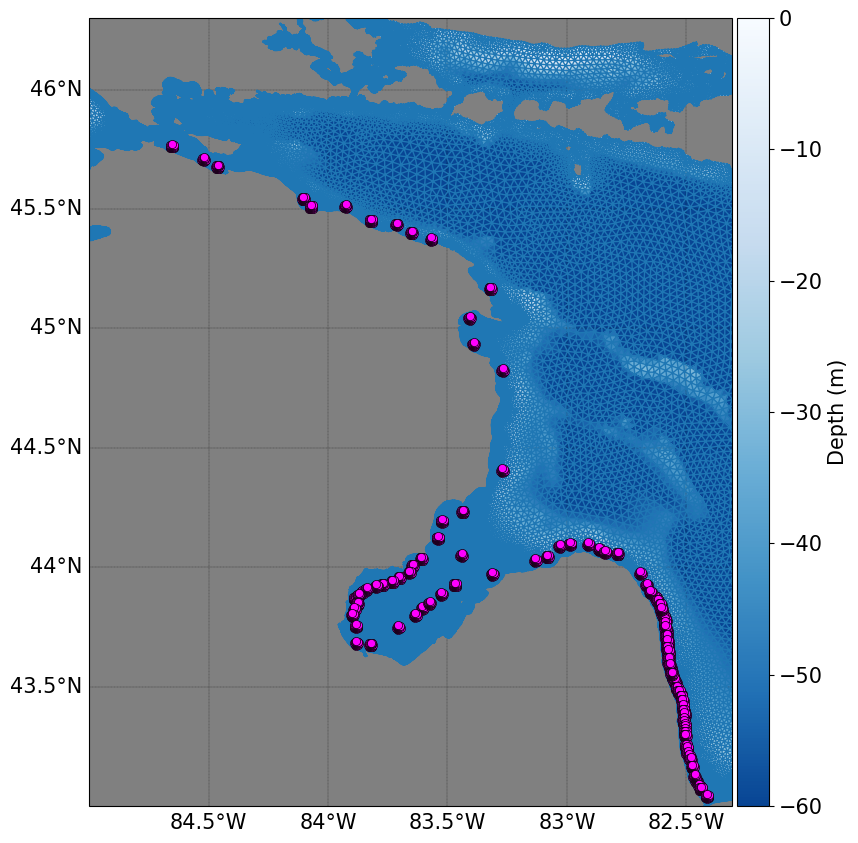

In [5]:
# Read the initial position file into a pandas DataFrame and skip the first line
df = pd.read_csv(f"{MODELLING_DIR}/input/initial_position/initial_positions_releasezone_intersection_multigroup_2_lastrevised.dat", sep = ' ',skiprows=1)
group_id = df.iloc[:,0]
lons = df.iloc[:,1] 
lats= df.iloc[:,2]

# Create figure

fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(),
                      font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
ax, plot = plotter.plot_field(ax, bathy, extents=extents_LH, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=35, color='fuchsia', edgecolors='black', linewidth=0.5, zorder=10)

# save the initial positions figure in the figure directory

plt.savefig(fig_path_initilapositions, dpi=300)

# Plot PT outputs

In [6]:
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'

In [14]:
# read the the nc files in the output directory
nc_files = [f for f in os.listdir(output_dir) if f.endswith('.nc')]
# Sort the files by date
# read the first file
ds = xr.open_dataset(os.path.join(output_dir, nc_files[0]))


In [10]:
ds

<xarray.Dataset> Size: 32MB
Dimensions:                   (time: 237, particles: 3364)
Coordinates:
  * time                      (time) datetime64[ns] 2kB 2023-01-01 ... 2023-0...
Dimensions without coordinates: particles
Data variables:
    group_id                  (particles) int32 13kB ...
    longitude                 (time, particles) float32 3MB ...
    latitude                  (time, particles) float32 3MB ...
    depth                     (time, particles) float32 3MB ...
    host_fvcom                (time, particles) int32 3MB ...
    error_status              (time, particles) int32 3MB ...
    in_domain                 (time, particles) int32 3MB ...
    is_beached                (time, particles) int32 3MB ...
    land_boundary_encounters  (time, particles) int32 3MB ...
    thetao                    (time, particles) float32 3MB ...
    so                        (time, particles) float32 3MB ...
Attributes:
    title:    PyLag -- Plymouth Marine Laboratory

In [16]:
#Create a list of file names
import re
import os
from datetime import timedelta
import gc
import matplotlib.pyplot as plt

# Custom sorting function to extract numerical part after "__"
def extract_sort_key(filename):
    match = re.search(r'__(\d+)\.nc$', filename)
    if match:
        return int(match.group(1))  # Extract the numeric identifier after "__"
    return float('inf')  # If no match, push the file to the end

# Process files
for file_name in sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key):
    sample_name = file_name
    file_name = os.path.join(output_dir, file_name)
    time_of_flight = timedelta(hours=12)
   
    # Set the extents
    extents = extents_LH
    
    # Create figure
    fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
    
    # Assuming grid_metrics_file_name, bathy, and cmap are defined elsewhere
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    plotter.plot_field(ax, bathy, extents=extents_LH, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed)
    
    viewer = Viewer(file_name, time_rounding=900)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    # Convert positions into lons/lats
    lons, lats = [viewer('longitude')[time_index, :].squeeze(), viewer('latitude')[time_index, :].squeeze()]
    
    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=5, color='fuchsia', edgecolors='black')
    
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, :],
                              viewer('latitude')[:time_index + 1, :])
    
    
    # Convert all pathline coordinates into lons/lats
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')
    
    output_file = os.path.join(fig_dir, f"{sample_name.split('.')[0]}.png")
    plt.savefig(output_file, dpi=300)
    plt.close(fig)
    gc.collect()

# Plotting three months output in one plot 

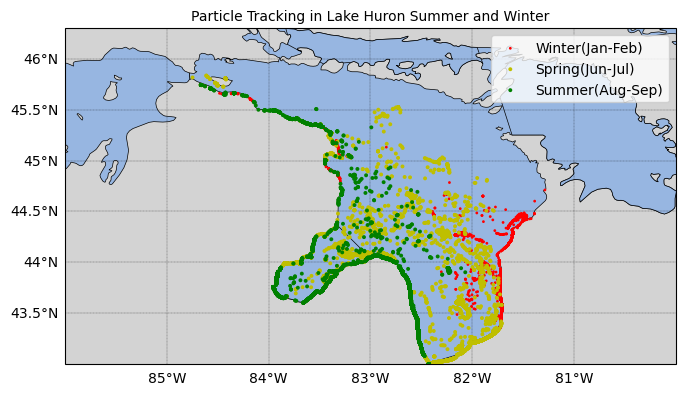

In [7]:
import numpy as np
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, ArakawaAPlotter


%matplotlib inline


# Plot options
font_size = 10

# Create figure
fig, ax = create_figure(figure_size=(20., 20.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='white')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                          font_size=font_size)

extents = [274,280, 43,46.3]
#extent=[276.5,276.8,44.8,45.5]
#extents=[276.5, 276, 43.58, 44]
# Add tracks from the ocean only run
# ----------------------------------
# PyLag file name
file_name = f'{out_dir}/FVCOM_Huron_2424_JanFeb_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=4, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=extents,label= 'Winter(Jan-Feb)')

# Add high resolution land
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=0.005, alpha=1, color='black')


# Add tracks from the ocean + stokes drift run
# --------------------------------------------
# PyLag file name
file_name = f'{out_dir}/FVCOM_Huron_2424_JunJul_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none', label = 'Spring(Jun-Jul)')

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='y')


# Add tracks from the ocean + leeway run
# --------------------------------------
# PyLag file name
file_name = f'{out_dir}/FVCOM_Huron_2424_AugSep_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='green', edgecolors='none', label = 'Summer(Aug-Sep)')
plt.legend()
plt.title('Particle Tracking in Lake Huron Summer and Winter', fontsize=font_size)

# Save the figure
output_file = os.path.join(fig_dir, 'tracks_LakeHuron_Summerwinter.jpeg')
plt.savefig(output_file, dpi=300)

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='b')

# plot particle tracking with Zoom in extents

In [19]:
out_dir ='/home/abolmaal/modelling/FVCOM/Huron/output/twomonth'

/tmp/ipykernel_307601/831347110.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


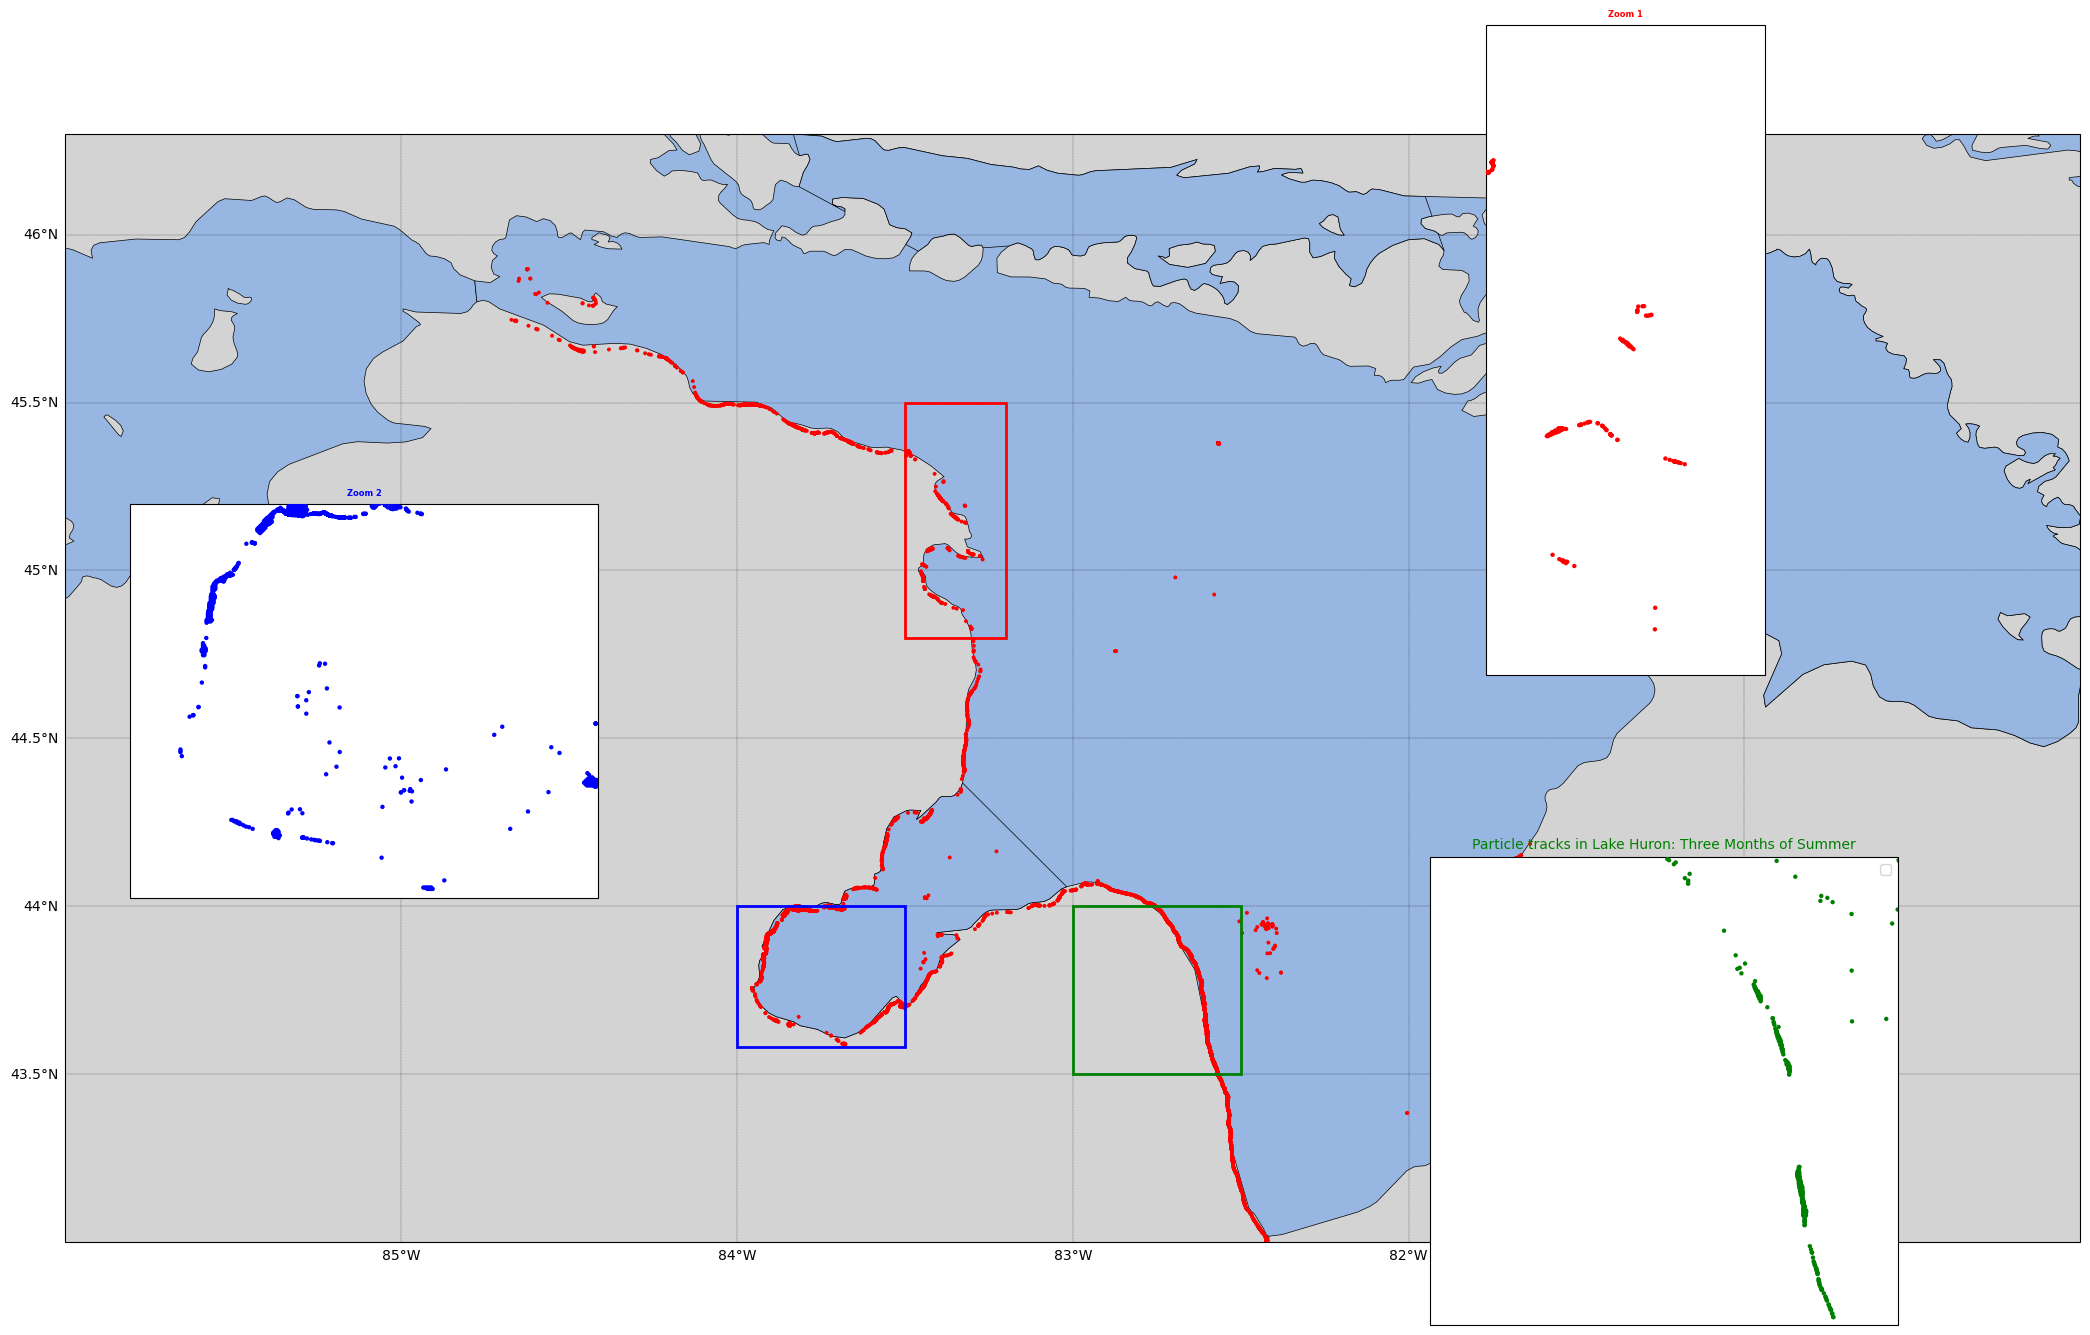

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, FVCOMPlotter

# ✅ Define plot options
font_size = 10

# ✅ Define main and zoomed-in extents
main_extents = [274, 280, 43, 46.3]  # Main map extent
zoom_extents_1 = [276.5, 276.8, 44.8, 45.5]  # Zoom-in 1
zoom_extents_2 = [276.5, 276, 43.58, 44]  # Zoom-in 2
zoom_extents_3 = [277.5, 277, 43.5, 44]  # Zoom-in 3

# ✅ Create figure with main map
fig = plt.figure(figsize=(26, 26))
ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_main.set_extent(main_extents, crs=ccrs.PlateCarree())

# ✅ Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, font_size=font_size)

# ✅ PyLag file name
file_name = f'{out_dir}/Fvcom_Huron_23_Aug__8.nc'

# ✅ Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# ✅ Plot final positions (red for summer)
plotter.scatter(ax_main,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=main_extents,
                label='JunJulAug')

# ✅ Add high-resolution land features
ax_main.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_main.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_main.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax_main.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)

# ✅ Plot paths (particle tracks)
# _ = plotter.plot_lines(ax_main,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=0.005, alpha=1, color='black')

file_name = f'{out_dir}/Fvcom_Huron_23_Oct__10.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none', label = 'Nov')

# ✅ Define inset positions relative to the figure (x, y, width, height)
inset_positions = [
    [0.60, 0.50, 0.25, 0.25],  # Top right
    [0.15, 0.40, 0.18, 0.18],  # Top left
    [0.65, 0.25,0.18, 0.18]   # Bottom center
]

# ✅ Define zoom extents
zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
colors = ['red', 'blue', 'green']

# ✅ Loop through the three insets
for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
    # ✅ Create inset axes manually
    left, bottom, width, height = inset_pos
    ax_inset = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
    ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())

    # ✅ Plot zoomed-in scatter points
    plotter.scatter(ax_inset,
                    viewer('longitude')[-1, :].squeeze(),
                    viewer('latitude')[-1, :].squeeze(),
                    s=10, color=color, edgecolors='none')

    # ✅ Plot paths inside zoomed-in inset
    # _ = plotter.plot_lines(ax_inset,
    #                        viewer('longitude')[:, :].squeeze(),
    #                        viewer('latitude')[:, :].squeeze(),
    #                        linewidth=0.05, alpha=1, color=color)

    # ✅ Set zoomed-in title
    ax_inset.set_title(f"Zoom {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

    # ✅ Remove axis ticks for zoom-in maps
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

    # ✅ Add rectangle to highlight zoomed-in region on main map
    rect = plt.Rectangle(
        (zoom_extent[0], zoom_extent[2]),
        zoom_extent[1] - zoom_extent[0],
        zoom_extent[3] - zoom_extent[2],
        linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
    )
    ax_main.add_patch(rect)  # ✅ Ensure the rectangle is added to the main map

# ✅ Add legend
plt.legend()
plt.title('Particle tracks in Lake Huron: Three Months of Summer', fontsize=font_size)

# ✅ Save the figure
output_file = os.path.join(fig_dir, 'tracks_LakeHuron_JunJulyAug.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# ✅ Show the plot
plt.show()

# plot the target group_id, group_number

In [ ]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Define the function to sort the files based on the time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the .nc extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify group_id and group_number for filtering
target_group_id = 57  # Change to your specific group_id
target_group_number = '57040'  # Change to your specific group_number

# Find the files and sort them
files = sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key)

# Prepare animation elements
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

# Initialize empty elements for animation
scatter = None
lines = None
time_text = ax.text(
    0.02, 0.95, '', transform=ax.transAxes, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5)
)

# Function to update animation frames
def update_frame(file_name):
    global scatter, lines  # Use global variables to update scatter and lines
    file_name = os.path.join(out_dir, file_name)

    # Load viewer for the file
    viewer = Viewer(file_name, time_rounding=25200)

    # Extract the date and time of flight
    date = viewer.date[0] + timedelta(hours=24)
    time_index = viewer.date.tolist().index(date)

    # Sanity checks for group_id and group_number
    group_ids = viewer('group_id')[:].squeeze()
    group_numbers = viewer('group_number')[:].squeeze()
    target_indices = (group_ids == target_group_id) & (group_numbers == target_group_number)

    if not target_indices.any():
        return  # Skip if no particles are found

    # Extract positions for the specific group_id and group_number
    lons, lats = [viewer('longitude')[time_index, target_indices].squeeze(),
                  viewer('latitude')[time_index, target_indices].squeeze()]

    # Dynamically calculate extent with a margin
    extent_margin = 0.5  # Add a larger margin to the extent
    extent = extents_LH
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Add high resolution land
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder = 10)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder = 10)
    ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5,zorder =10)


    # Clear previous scatter and lines
    if scatter:
        scatter.remove()
    if lines:
        for line in lines:
            line.remove()

    # Plot particle final positions
    scatter = ax.scatter(lons, lats, s=200, color='#e50000', edgecolors='black', transform=ccrs.PlateCarree(),zorder = 30)

    # Extract pathlines
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                              viewer('latitude')[:time_index + 1, target_indices])

    # Plot the particle pathlines
    # lines = []
    # for i in range(lons_paths.shape[1]):  # Iterate over particles
    #     line, = ax.plot(lons_paths[:, i], lats_paths[:, i], linewidth=0.5, alpha=1, color='#0504aa', transform=ccrs.PlateCarree(),zorder = 20)
    #     lines.append(line)

    # Update the title
    time_text.set_text(f"Time: {date.strftime('%Y-%m-%d %H:%M:%S')}")

    # Clean up memory
    del viewer
    gc.collect()

# Create animation
ani = FuncAnimation(fig, update_frame, frames=files, interval=1000, repeat=False)

# Save the animation
output_file = os.path.join(fig_dir, f"particle_animation_group_{target_group_id}_{target_group_number}.mp4")
ani.save(output_file, fps=1, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

In [ ]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Define the function to sort the files based on time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify `group_id` and multiple `group_number` values for filtering
target_group_id = 57  # Change to your specific group_id
target_group_numbers = ['57040', '57041', '57042']  # List of group numbers

# Find the files and sort them
files = sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key)

# Prepare animation elements
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=12)

# Initialize empty elements for animation
scatter = []
lines = []
time_text = ax.text(
    0.02, 0.95, '', transform=ax.transAxes, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5)
)

# Define colors for each group number
colors = plt.cm.jet(np.linspace(0, 1, len(target_group_numbers)))

# Function to update animation frames
def update_frame(file_name):
    global scatter, lines
    file_name = os.path.join(output_dir, file_name)

    # Load viewer for the file
    viewer = Viewer(file_name, time_rounding=21600)

    # Extract the date and time of flight
    date = viewer.date[0] + timedelta(hours=12)
    time_index = viewer.date.tolist().index(date)

    # Sanity checks for `group_id` and multiple `group_number` values
    group_ids = viewer('group_id')[:].squeeze()
    group_numbers = viewer('group_number')[:].squeeze()
    print(f"Available group_ids: {np.unique(group_ids)}")
    print(f"Available group_numbers: {np.unique(group_numbers)}")
    # Check if any group has data for this frame
    if not any(((group_ids == target_group_id) & (group_numbers == int(group_number))).any() for group_number in target_group_numbers):
        print(f"No particles found for any group at {date}, skipping frame.")
        return

    # Clear previous scatter and lines
    for scatter_point in scatter:
        scatter_point.remove()
    scatter.clear()

    for line in lines:
        line.remove()
    lines.clear()

    # Set map extent and add map features
    extent = extents_LH
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)  # Low zorder
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=2)  # Higher than land
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5, zorder=2)

    # Plot particle final positions for each group_number
    for group_number, color in zip(target_group_numbers, colors):
        group_idx = (group_ids == target_group_id) & (group_numbers == int(group_number))
        if not group_idx.any():  # Skip if no particles are found for this group_number
            print(f"No particles found for group_number {group_number} at {date}")
            continue

        # Extract positions for the current group_number
        group_lons = viewer('longitude')[time_index, group_idx].squeeze()
        group_lats = viewer('latitude')[time_index, group_idx].squeeze()

        # Adjust longitude for consistency with projection
        #group_lons = np.where(group_lons < 180, group_lons + 360, group_lons)

        # Plot the scatter points
        scatter_point = ax.scatter(
            group_lons,
            group_lats,
            s=200, color=color, edgecolors='black', label=f'Group {group_number}',
            transform=ccrs.PlateCarree(), zorder=30  # Higher zorder for points
        )
        scatter.append(scatter_point)

    # Extract and plot pathlines for each group_number
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                              viewer('latitude')[:time_index + 1, target_indices])
    for i in range(lons_paths.shape[1]):  # Iterate over particles
        line, = ax.plot(
            lons_paths[:, i], lats_paths[:, i], linewidth=0.5, alpha=1, color='#0504aa',
            transform=ccrs.PlateCarree(), zorder=2.5  # Below scatter
        )
        lines.append(line)

    # Update the title
    time_text.set_text(f"Time: {date.strftime('%Y-%m-%d %H:%M:%S')}")

    # Clean up memory
    del viewer
    gc.collect()

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Create animation
ani = FuncAnimation(fig, update_frame, frames=files, interval=1000, repeat=False)

# Save the animation
output_file = os.path.join(fig_dir, f"particle_animation_group_{target_group_id}_multiple_groups.mp4")
ani.save(output_file, fps=1, extra_args=['-vcodec', 'libx264'])

plt.close(fig)